In [1]:
import pandas as pd
import numpy as np

from keras.preprocessing import text, sequence
from keras.utils.np_utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, Input, Flatten, Embedding, LSTM, SpatialDropout1D, Dropout, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *


from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Eğitimin Başarımı')
    plt.plot(x, val_acc, 'r', label='Doğrulama Başarımı')
    plt.title('Eğitim ve Doğrulama Başarımı')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Eğitim kaybı')
    plt.plot(x, val_loss, 'r', label='Doğrulama kaybı')
    plt.title('Eğitim ve Doğrulama Kaybı')
    plt.legend()
    plt.show()
    

In [3]:
data = fetch_20newsgroups()

print("------------ VERI ------------")
print(data.data[0].strip())
print("\nLABEL:", data.target_names[data.target[0]],
      "=", data.target[0])

------------ VERI ------------
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----

LABEL: rec.autos = 7


In [4]:
categories = ['comp.graphics', 'sci.space', 'talk.politics.guns',
            'rec.autos', 'sci.crypt', 'sci.electronics', 'comp.sys.ibm.pc.hardware']

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), categories=categories ) 



df_ = pd.DataFrame([newsgroups.data, newsgroups.target.tolist()]).T
df_.columns = ['text', 'target']
targets = pd.DataFrame(newsgroups.target_names)
targets.columns=['topic']
df = pd.merge(df_, targets, left_on='target', right_index=True)
df.head()

,text,target,topic
0,I have just a few quick questions. Does anyon...,1,comp.sys.ibm.pc.hardware
2,Maybe I should have been clearer. I have a In...,1,comp.sys.ibm.pc.hardware
4,Anybody use CD Speedway out there? Is it as g...,1,comp.sys.ibm.pc.hardware
9,"Hi,\n Can somebody tell me step by step how...",1,comp.sys.ibm.pc.hardware
11,I have a WANGTEK tape controller card (Revisio...,1,comp.sys.ibm.pc.hardware


In [5]:
np.unique(df.target)

array([0, 1, 2, 3, 4, 5, 6], dtype=object)

In [6]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return " ".join(result)

In [7]:
processed_docs = df['text'].map(preprocess)
processed_docs[:5]

0     quick question cyrix problem second cyric moth...
2     mayb clearer intel like motherboard local vend...
4     anybodi speedway good hate wait finish load le...
9     somebodi tell step step kalok exist maxtor sta...
11    wangtek tape control card revis syto backup ba...
Name: text, dtype: object

In [8]:
df['cleaned_text'] = processed_docs

In [9]:
df.head()

,text,target,topic,cleaned_text
0,I have just a few quick questions. Does anyon...,1,comp.sys.ibm.pc.hardware,quick question cyrix problem second cyric moth...
2,Maybe I should have been clearer. I have a In...,1,comp.sys.ibm.pc.hardware,mayb clearer intel like motherboard local vend...
4,Anybody use CD Speedway out there? Is it as g...,1,comp.sys.ibm.pc.hardware,anybodi speedway good hate wait finish load le...
9,"Hi,\n Can somebody tell me step by step how...",1,comp.sys.ibm.pc.hardware,somebodi tell step step kalok exist maxtor sta...
11,I have a WANGTEK tape controller card (Revisio...,1,comp.sys.ibm.pc.hardware,wangtek tape control card revis syto backup ba...


In [10]:
maxlen = 1000
max_words = 20000

In [11]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df.cleaned_text)
sequences = tokenizer.texts_to_sequences(df.cleaned_text)
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 25388 unique tokens.


In [12]:
data = pad_sequences(sequences, maxlen=maxlen)

labels = to_categorical(np.asarray(df.target))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (6817, 1000)
Shape of label tensor: (6817, 7)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5453, 1000) (5453, 7)
(1364, 1000) (1364, 7)


In [14]:
import os

glove_dir = './glove/'

embeddings_index = {}

f = open(os.path.join(glove_dir, "glove.6B.100d.txt"))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print("found %s word vectors." % len(embeddings_index))

found 400000 word vectors.


In [15]:
embedding_dim = 100
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

count_zero = 0
for word, idx in word_index.items():
    embed_vector = embeddings_index.get(word)
    if embed_vector is not None:
        count_zero += 1
        embedding_matrix[idx] = embed_vector
        
#print("embedding_matrix val:\n",embedding_matrix)

In [16]:
model = Sequential()
model.add(Embedding(len(word_index) + 1, embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True))

model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Dropout(0.2))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(35))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         2538900   
_________________________________________________________________
conv1d (Conv1D)              (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 199, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 199, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 39, 128)           0

In [17]:
histroy = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/15
43/43 [==============================] - 81s 2s/step - loss: 1.9265 - acc: 0.1814 - val_loss: 1.8277 - val_acc: 0.3218
Epoch 2/15
43/43 [==============================] - 76s 2s/step - loss: 1.5238 - acc: 0.4134 - val_loss: 1.1489 - val_acc: 0.5806
Epoch 3/15
43/43 [==============================] - 76s 2s/step - loss: 1.0415 - acc: 0.6123 - val_loss: 0.8699 - val_acc: 0.7089
Epoch 4/15
43/43 [==============================] - 79s 2s/step - loss: 0.7777 - acc: 0.7321 - val_loss: 0.7822 - val_acc: 0.7331
Epoch 5/15
43/43 [==============================] - 74s 2s/step - loss: 0.6047 - acc: 0.7977 - val_loss: 0.7712 - val_acc: 0.7383
Epoch 6/15
43/43 [==============================] - 74s 2s/step - loss: 0.4610 - acc: 0.8460 - val_loss: 0.7661 - val_acc: 0.7625
Epoch 7/15
43/43 [==============================] - 79s 2s/step - loss: 0.3392 - acc: 0.8892 - val_loss: 0.8404 - val_acc: 0.7588
Epoch 8/15
43/43 [==============================] - 74s 2s/step - loss: 0.2822 - acc: 0.90

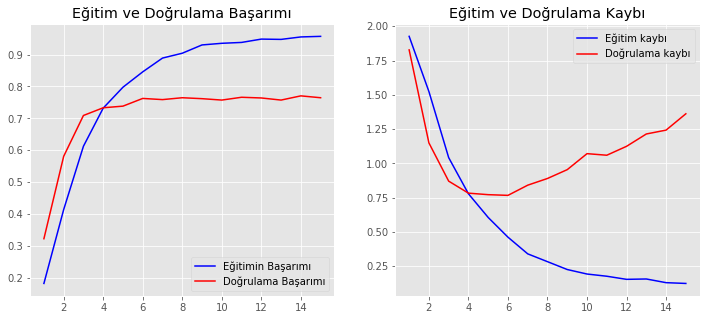

In [20]:
plot_history(histroy)

In [21]:
score, acc = model.evaluate(X_test, y_test, batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

11/11 [==============================] - 5s 429ms/step - loss: 1.3614 - acc: 0.7647
Test score: 1.3614449501037598
Test accuracy: 0.7646627426147461


In [24]:
model2 = Sequential()
model2.add(Embedding(len(word_index) + 1, embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True))

model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(5))
model2.add(Dropout(0.2))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(5))
model2.add(Dropout(0.2))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(MaxPooling1D(35))
model2.add(Flatten())
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(7, activation='softmax'))
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model2.summary()


histroy2 = model2.fit(X_train, y_train, epochs=6, batch_size=128, validation_data=(X_test, y_test))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1000, 100)         2538900   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 996, 128)          64128     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 199, 128)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 199, 128)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 195, 128)          82048     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 39, 128)           0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 39, 128)          

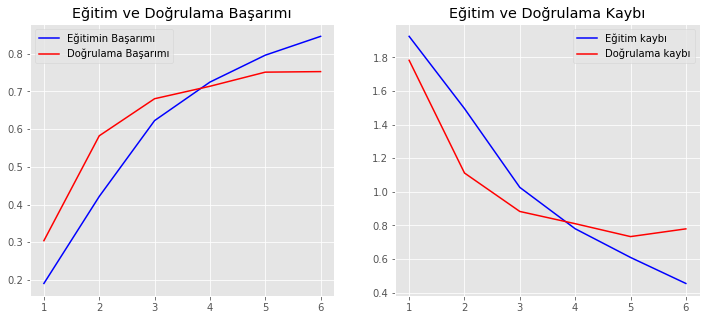

In [25]:
plot_history(histroy2)

In [26]:
score, acc = model2.evaluate(X_test, y_test, batch_size=128)
print('Test score:', score)
print('Test accuracy:', acc)

11/11 [==============================] - 5s 422ms/step - loss: 0.7789 - acc: 0.7522
Test score: 0.7788960933685303
Test accuracy: 0.7521994113922119


In [27]:
y_pred = model2.predict(X_test)

In [29]:
y_pred_class = np.argmax(y_pred, axis=1)
y_pred_class

array([0, 5, 4, ..., 6, 4, 4])

In [31]:
_class = np.argmax(y_test, axis=1)

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(classification_report(_class, y_pred_class))

              precision    recall  f1-score   support

           0       0.84      0.72      0.77       220
           1       0.79      0.74      0.77       191
           2       0.74      0.71      0.73       191
           3       0.87      0.76      0.81       194
           4       0.53      0.72      0.61       197
           5       0.79      0.83      0.81       199
           6       0.82      0.78      0.80       172

    accuracy                           0.75      1364
   macro avg       0.77      0.75      0.76      1364
weighted avg       0.77      0.75      0.76      1364

